In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import glob


In [2]:
def process_data(env_path):
    data = []
    min_size = np.inf
    for path in glob.glob(env_path + '*/'):
        data_set = pickle.load(open(path + 'reward_data.pkl', 'rb'))
        data_set = np.stack(data_set)
        if data_set[-1,0] < min_size:
            min_size = data_set[-1,0]
        data.append(data_set)
    x_samples = np.linspace(0, min_size)
    interp_data = []
    for data_set in data:
        _x = data_set[:,0]
        _y = data_set[:,1]
        interp_data.append(np.interp(x_samples, _x, _y))
    
#     data = np.stack([d[:min_size] for d in data])
    mean = np.mean(interp_data, axis=0)
    std  = np.std(interp_data, axis=0)
    data_log = {'x' : x_samples, 'mean' : mean, 'std' : std}
    return data_log

def plot_data(log, label):
    plt.plot(log['x'], log['mean'], label=label)
    plt.fill_between(log['x'], 
                    log['mean']-log['std']*0.95, log['mean']+log['std']*0.95,
                    alpha=0.2)


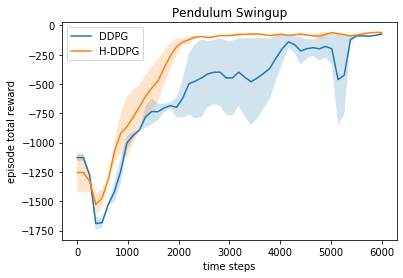

In [3]:

hddpg_data = process_data('./benchmarks/data/PendulumEnv/h_ddpg/')
ddpg_data = process_data('./benchmarks/data/PendulumEnv/ddpg/')


plot_data(ddpg_data, 'DDPG')
plot_data(hddpg_data, 'H-DDPG')

plt.xlabel('time steps')
plt.ylabel('episode total reward')
plt.title('Pendulum Swingup')

plt.legend()



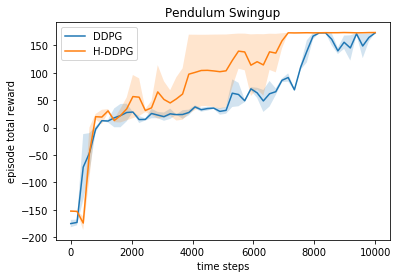

In [4]:
hddpg_data = process_data('./benchmarks/data/InvertedPendulumSwingupBulletEnv/h_ddpg/')
ddpg_data = process_data('./benchmarks/data/InvertedPendulumSwingupBulletEnv/ddpg/')


plot_data(ddpg_data, 'DDPG')
plot_data(hddpg_data, 'H-DDPG')

plt.xlabel('time steps')
plt.ylabel('episode total reward')
plt.title('Pendulum Swingup')

plt.legend()

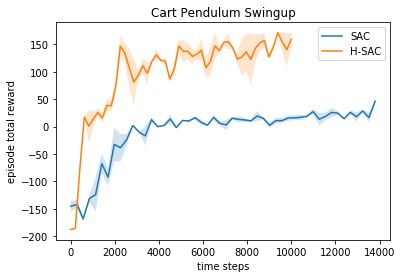

In [165]:
hybrid_data = process_data('./examples/sac/data/InvertedPendulumSwingupBulletEnv/')
sac_data = process_data('./benchmark_examples/sac/data/InvertedPendulumSwingupBulletEnv/')

# hddpg_data = process_data('./examples/ddpg/data/InvertedPendulumSwingupBulletEnv/')
# ddpg_data = process_data('./benchmark_examples/ddpg/data/InvertedPendulumSwingupBulletEnv/')

plot_data(sac_data, 'SAC')
plot_data(hybrid_data, 'H-SAC')

# plot_data(ddpg_data, 'DDPG', 'b')
# plot_data(hddpg_data, 'H-DDPG', 'r')

plt.xlabel('time steps')
plt.ylabel('episode total reward')
plt.title('Cart Pendulum Swingup')

plt.legend()

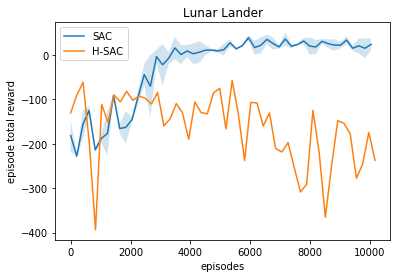

In [187]:
# hddpg_data = process_data('./examples/ddpg/data/LunarLanderContinuousEnv/')
# ddpg_data = process_data('./benchmark_examples/ddpg/data/LunarLanderContinuousEnv/')

# plot_data(ddpg_data, 'DDPG', 'b')
# plot_data(hddpg_data, 'H-DDPG', 'r')

hddpg_data = process_data('./examples/sac/data/LunarLanderContinuousEnv/')
ddpg_data = process_data('./benchmark_examples/sac/data/LunarLanderContinuousEnv/')

plot_data(ddpg_data, 'SAC')
plot_data(hddpg_data, 'H-SAC')

# plt.plot(sac_data[1][:,0], sac_data[1][:,1])

# plt.plot(hybrid_data[1][:,0], hybrid_data[1][:,1])

plt.xlabel('episodes')
plt.ylabel('episode total reward')
plt.title('Lunar Lander')

plt.ylim(-300, 100)
plt.legend()

In [182]:
hybrid_data = process_data('./examples/data/HopperBulletEnv/')
sac_data = process_data('./benchmark_examples/data/HopperBulletEnv/')

plot_data(sac_data, 'SAC', 'b')
plot_data(hybrid_data, 'H-SAC', 'r')

# plt.plot(hybrid_data[0].T)

plt.xlabel('time steps')
plt.ylabel('episode total reward')
plt.title('Hopper Env')

plt.legend()

TypeError: plot_data() takes 2 positional arguments but 3 were given